In [40]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
import altair as alt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('../data/train_data.zip')

In [3]:
df.drop(labels=['external_id','unacast_session_count'],axis=1).columns


Index(['month', 'year', 'monthly_number_of_sessions',
       'monthly_unique_sessions', 'monthly_repeated_sessions',
       'monthly_avg_length_of_session', 'monthly_avg_light_activity',
       'monthly_avg_moderate_activity', 'monthly_avg_vigorous_activity',
       'monthly_count_slide_single',
       ...
       'avg_wind_8_9', 'avg_wind_9_10', 'avg_wind_10_11', 'avg_wind_11_12',
       'avg_wind_12_above', 'perfect_days', 'hpi',
       'state_and_local_amount_per_capita', 'state_amount_per_capita',
       'local_amount_per_capita'],
      dtype='object', length=859)

In [54]:
# Tried running overall PCA, requires dealing with nulls

# pca_all = PCA()
# pca_all.fit(df.drop(labels=['external_id','unacast_session_count'],axis=1).select_dtypes(include=[np.number]))

What you will find in this notebook:
    
1. Data Overview

2. simple correlation

3. Variance

4. PCA


### Executive summary:

There are no Null values at all, however there are many zero values, with some columns having over 90% of the values as zeros, however this is most likely not an error, and just the correct data from the census.

There are two types of columns with a relatively high variance compared to the others: 
    - Columns with high rates of zero 
    - Columns with monetary data, such as income
While the second may be addressed with some standardizations (change of base unit, say from dollars to thousends of dollars), the first is rather problematic in that sense (linear transformation wont move the zero values well, might skew variance).

runnign PCA it looks like 99.9% of the variance in the census data can be explained in 27 eigenvectors. 

### Data Overview

Started off with a very rough overview of the census variables and the topic on which they have data.(table above)
Reccomend going through once with the variable description table open and look through them.

# Rough overview of census data by topic

| category (roughly)                                              	| No. of Columns 	| sets of variables 	| First Column Index 	|
|-----------------------------------------------------------------	|----------------	|-------------------	|--------------	|
| Sex by age                                                      	| 14             	| 1                 	| 134          	|
| Commute                                                         	| 12             	| 2                 	| 148          	|
| Under 18                                                        	| 9              	| 1                 	| 160          	|
| Child age by family type (single father/mother, married )       	| 20             	| 1                 	| 169          	|
| Relationship to child (adopted, biological, etc’)               	| 16             	| 2                 	| 189          	|
| Median Family Income                                            	| 3              	| 1                 	| 205          	|
| Houshold type (people in houshold)                              	| 34             	| 4                 	| 208          	|
| Marital Status                                                  	| 19             	| 1                 	| 242          	|
| Birth by women (age and marital status)                         	| 13             	| 2                 	| 261          	|
| Education                                                       	| 12             	| 2                 	| 274          	|
| Spoken language – children                                      	| 6              	| 1                 	| 286          	|
| Poverty income and government food-stamps (includes gini)       	| 72             	| 10                	| 292          	|
| Age of children (by family and employment)                      	| 27             	| 1                 	| 364          	|
| Work (hours, employment)                                        	| 9              	| 2                 	| 391          	|
| Housing (vacancies, tenure, rent, mortgage) – 3 income by house 	| 29             	| 7                 	| 400          	|
| Health and disability                                           	| 6              	| 3                 	| 429          	|
| Sex by age                                                      	| 16             	| 1                 	| 435          	|
| Education (current enrolment)                                   	| 17             	| 2                 	| 451          	|
| commute (time)                                                  	| 4              	| 2                 	| 468          	|
| Houshold by size                                                	| 2              	| 1                 	| 472          	|
| Health Insurance                                                	| 4              	| 1                 	| 478          	|
| Fertility (mother and baby weight)                              	| 18             	| 3                 	| 482          	|

In [4]:
# creating the DF of census columns + primary key
df_census = pd.concat([df.iloc[:,0:3],df.iloc[:,132:498],df.loc[:,'unacast_session_count']],axis=1, join='outer',sort='false')
df_census.shape

(50120, 370)

In [5]:
df_census.columns

Index(['external_id', 'month', 'year', 'B20004e10', 'B11016e1', 'B12001e12',
       'B20004e11', 'B19125e1', 'B12001e13', 'B23008e22',
       ...
       'fertility_rate_2010', 'fertility_rate_2011', 'fertility_rate_2012',
       'fertility_rate_2013', 'fertility_rate_2014', 'fertility_rate_2015',
       'fertility_rate_2016', 'fertility_rate_2017', 'fertility_rate_2018',
       'unacast_session_count'],
      dtype='object', length=370)

### Simple correlation

Calculated a simple correlation between the sessions each census column (not sure there is too much meaning to be had here, since columns are typically in "sets") and plotted a histogram, generally between -0.1 and 0.1 correlation.

In [5]:
corr = df_census.corr()

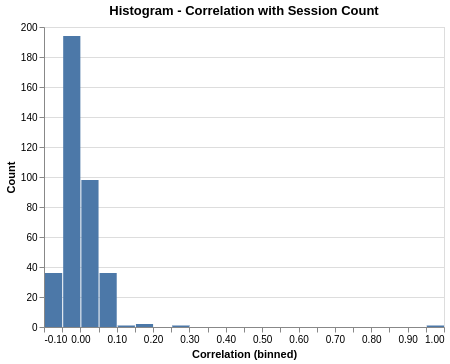

In [6]:
alt.Chart(corr).mark_bar().encode(
    alt.X("unacast_session_count:Q", bin=alt.Bin(maxbins=30),title="Correlation (binned)"),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Correlation with Session Count'
)

### Variance

In order to faithfully look through the variance in each column and map outliers needed to look into the rate of null and zero values.
None of the columns have nulls, however some have high rates of zeros, this unfortunatly is probably not an error, and how to deal with this is something to contemplate.

In addition i looked into the Coefficient of Variance index (standard deviation over the mean), in order to get a look at a stadardized variance since all monetary have relatively high variance due to the unit, there is (unsurprisinly) a correlation between having many zero values (low mean) and a higher CoV score, and so this isnt nessecerily indicitive of anything, but i found it a little interesting as there are less then 30 columns with a CoV above 2, and it replaces the variance plot due to the scale disruptencies.



In [7]:
null_val = df_census.isnull().sum(axis = 0)/df_census.shape[0]
zero_val = (df_census == 0).sum(axis = 0)/df_census.shape[0]

In [8]:
df_desc = df_census.describe().T#(verbose=True)


In [55]:
# coefficiant of variation creation
df_desc["CoV"] = (df_desc["std"])/df_desc["mean"]
df_desc['zero'] = zero_val
df_desc['null'] = null_val
df_desc.sort_values(by=['zero'], axis=0,ascending=False)

count         mean           std      min      25%  \
B10010e3               52626.0  1751.410615  10410.445326     0.00     0.00   
B13016e9               52626.0     1.124501      5.046645     0.00     0.00   
B11005e10              52626.0     1.556265      6.011438     0.00     0.00   
B17012e7               52626.0     2.472466      9.286963     0.00     0.00   
B23008e11              52626.0     3.189545     12.863499     0.00     0.00   
...                        ...          ...           ...      ...      ...   
fertility_rate_2003    52626.0    68.204254     10.229943    32.10    62.80   
avg_age_of_mother      52626.0    28.298947      1.238352    25.69    27.45   
avg_birth_weight       52626.0  3274.861433     55.950288  3028.16  3236.53   
year                   52626.0  2018.428571      0.494876  2018.00  2018.00   
unacast_session_count  49967.0   135.281086    534.126771     1.00    24.00   

                            50%      75%        max       CoV      zero  \
B10010e3                  0.000     0.00  225417.00  5.944035  0.960495   
B13016e9                  0.000     0.00      78.00  4.487896  0.923384   
B11005e10                 0.000     0.00     119.00  3.862734  0.890263   
B17012e7                  0.000     0.00     110.00  3.756154  0.882283   
B23008e11                 0.000     0.00     195.00  4.033020  0.881883   
...                         ...      ...        ...       ...       ...   
fertility_rate_2003      67.070    71.84     120.61  0.149990  0.000000   
avg_age_of_mother        28.040    28.99      32.54  0.043760  0.000000   
avg_birth_weight       3273.455  3317.62    3438.81  0.017085  0.000000   
year                   2018.000  2019.00    2019.00  0.000245  0.000000   
unacast_session_count    57.000   123.00   44860.00  3.948274  0.000000   

                           null  
B10010e3               0.000000  
B13016e9               0.000000  
B11005e10              0.000000  
B17012e7               0.000000  
B23008e11              0.000000  
...                         ...  
fertility_rate_2003    0.000000  
avg_age_of_mother      0.000000  
avg_birth_weight       0.000000  
year                   0.000000  
unacast_session_count  0.050526  

[369 rows x 11 columns]

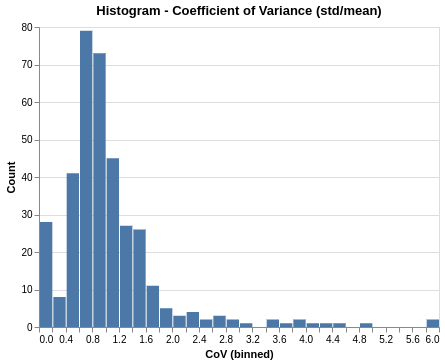

In [10]:
alt.Chart(df_desc).mark_bar().encode(
    alt.X("CoV:Q", bin=alt.Bin(maxbins=30)),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Coefficient of Variance (std/mean)'
)


In [11]:
# Count of no. of columns with a CoV higher then 2, one of which is the session counts
sum(df_desc.CoV>2)#-df_desc.shape[0]

26

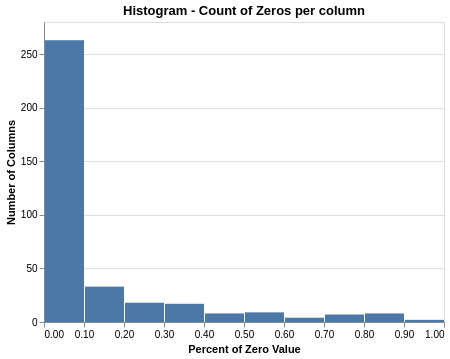

In [12]:
alt.Chart(df_desc).mark_bar().encode(
    alt.X("zero:Q", bin=alt.Bin(step=0.1), title="Percent of Zero Value"),
    y=alt.Y('count()', title="Number of Columns")
).properties(
    title="Histogram - Count of Zeros per column"
)

In [13]:
# Count of no. of columns with a more then 50% of values being zero
sum(df_desc.zero>0.5)#-df_desc.shape[0]

30

**There are no missing (null) values**

In [14]:
df_desc.sort_values(by=['CoV'], axis=0,ascending=False)[df_desc['std']>1000]

/home/tani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


count          mean           std  min      25%      50%  \
B10010e3   52626.0   1751.410615  10410.445326  0.0      0.0      0.0   
B10010e2   52626.0  12371.421389  30795.083914  0.0      0.0      0.0   
B10010e1   52626.0  34336.247007  48877.267196  0.0      0.0      0.0   
B20004e14  52626.0   7732.168795  10878.889502  0.0      0.0      0.0   
B20004e8   52626.0  17137.751796  17980.937803  0.0      0.0  18232.0   
...            ...           ...           ...  ...      ...      ...   
B20004e1   52626.0  40710.157622  15387.451209  0.0  30564.0  37487.0   
B20004e16  52626.0  29098.991221  10878.022868  0.0  23688.0  29400.0   
B20004e3   52626.0  29666.148444  10573.786692  0.0  24357.0  30107.0   
B20004e13  52626.0  33048.592179  10906.734678  0.0  25563.0  31409.0   
B20004e4   52626.0  36048.179170  10723.556780  0.0  29855.0  35546.5   

               75%       max       CoV      zero  null  
B10010e3       0.0  225417.0  5.944035  0.960495   0.0  
B10010e2       0.0  250001.0  2.489211  0.818835   0.0  
B10010e1   62946.0  250001.0  1.423489  0.575020   0.0  
B20004e14  15486.0   82604.0  1.406965  0.583001   0.0  
B20004e8   29194.0  250001.0  1.049201  0.418994   0.0  
...            ...       ...       ...       ...   ...  
B20004e1   47805.0  155574.0  0.377976  0.001197   0.0  
B20004e16  35156.0  120417.0  0.373828  0.048284   0.0  
B20004e3   35308.0  103973.0  0.356426  0.038707   0.0  
B20004e13  39694.0   80507.0  0.330021  0.003192   0.0  
B20004e4   41724.0  120347.0  0.297478  0.012769   0.0  

[66 rows x 11 columns]

Income columns have high variability, consider lowering the scale (from dollars to hundresds of dollars say to lower the std number)
B19125e2 - 2016 census: Median Family Income by Presence of Own Children: With own children of the householder under 18 years

 <font size="3"> Relationship between rate of 0 value and std - potantially messes up PCA a little.</font> 

In [15]:
df_desc[df_desc['zero']>0.6]

count          mean           std  min  \
B23008e24                            52626.0      6.289306     18.568757  0.0   
B23008e20                            52626.0      9.130886     23.954702  0.0   
B10010e2                             52626.0  12371.421389  30795.083914  0.0   
B17012e7                             52626.0      2.472466      9.286963  0.0   
B11005e10                            52626.0      1.556265      6.011438  0.0   
B10010e3                             52626.0   1751.410615  10410.445326  0.0   
B16007e7                             52626.0     10.270950     50.738755  0.0   
B23008e11                            52626.0      3.189545     12.863499  0.0   
B09002e11                            52626.0      8.355148     19.301465  0.0   
B09002e10                            52626.0     12.470870     23.564779  0.0   
B09002e12                            52626.0      4.249002     11.552493  0.0   
B23025e6                             52626.0     16.312849     97.306223  0.0   
B11005e9                             52626.0      3.973663     11.644726  0.0   
B23008e7                             52626.0      3.752195     12.991666  0.0   
B23008e6                             52626.0      8.918994     20.020796  0.0   
B09001e10                            52626.0      3.124102     13.223880  0.0   
B11005e8                             52626.0      5.529928     13.243388  0.0   
B13016e3                             52626.0      2.517558      8.937388  0.0   
B13016e8                             52626.0      3.062650      9.387281  0.0   
B13016e9                             52626.0      1.124501      5.046645  0.0   
four_or_more_in_nonfamily_household  52626.0      6.450918     16.709071  0.0   

                                     25%  50%   75%       max       CoV  \
B23008e24                            0.0  0.0   0.0     247.0  2.952434   
B23008e20                            0.0  0.0   7.0     329.0  2.623481   
B10010e2                             0.0  0.0   0.0  250001.0  2.489211   
B17012e7                             0.0  0.0   0.0     110.0  3.756154   
B11005e10                            0.0  0.0   0.0     119.0  3.862734   
B10010e3                             0.0  0.0   0.0  225417.0  5.944035   
B16007e7                             0.0  0.0   0.0    1293.0  4.940026   
B23008e11                            0.0  0.0   0.0     195.0  4.033020   
B09002e11                            0.0  0.0   9.0     243.0  2.310129   
B09002e10                            0.0  0.0  16.0     222.0  1.889586   
B09002e12                            0.0  0.0   0.0     127.0  2.718872   
B23025e6                             0.0  0.0   3.0    2514.0  5.965005   
B11005e9                             0.0  0.0   0.0     246.0  2.930476   
B23008e7                             0.0  0.0   0.0     139.0  3.462418   
B23008e6                             0.0  0.0   9.0     190.0  2.244737   
B09001e10                            0.0  0.0   0.0     190.0  4.232858   
B11005e8                             0.0  0.0   7.0     246.0  2.394857   
B13016e3                             0.0  0.0   0.0      90.0  3.550023   
B13016e8                             0.0  0.0   0.0     124.0  3.065085   
B13016e9                             0.0  0.0   0.0      78.0  4.487896   
four_or_more_in_nonfamily_household  0.0  0.0   7.0     318.0  2.590185   

                                         zero  null  
B23008e24                            0.769753   0.0  
B23008e20                            0.716281   0.0  
B10010e2                             0.818835   0.0  
B17012e7                             0.882283   0.0  
B11005e10                            0.890263   0.0  
B10010e3                             0.960495   0.0  
B16007e7                             0.794892   0.0  
B23008e11                            0.881883   0.0  
B09002e11                            0.691141   0.0  
B09002e10                            0.606943   0.0  
B09002e12  

In [16]:
df_desc[df_desc['CoV']>2]

count          mean           std  min  \
B23008e24                            52626.0      6.289306     18.568757  0.0   
B23008e20                            52626.0      9.130886     23.954702  0.0   
B08301e10                            52626.0     82.443735    196.200648  0.0   
B17012e6                             52626.0     12.708699     26.789263  0.0   
B16007e5                             52626.0     26.825219     58.732053  0.0   
B10010e2                             52626.0  12371.421389  30795.083914  0.0   
B17012e7                             52626.0      2.472466      9.286963  0.0   
B11005e10                            52626.0      1.556265      6.011438  0.0   
B10010e3                             52626.0   1751.410615  10410.445326  0.0   
B16007e7                             52626.0     10.270950     50.738755  0.0   
B23008e11                            52626.0      3.189545     12.863499  0.0   
B09002e11                            52626.0      8.355148     19.301465  0.0   
B09002e12                            52626.0      4.249002     11.552493  0.0   
B23025e6                             52626.0     16.312849     97.306223  0.0   
B11005e9                             52626.0      3.973663     11.644726  0.0   
B23008e7                             52626.0      3.752195     12.991666  0.0   
B23008e6                             52626.0      8.918994     20.020796  0.0   
B09001e10                            52626.0      3.124102     13.223880  0.0   
B11005e8                             52626.0      5.529928     13.243388  0.0   
B13016e3                             52626.0      2.517558      8.937388  0.0   
B13016e8                             52626.0      3.062650      9.387281  0.0   
B13016e9                             52626.0      1.124501      5.046645  0.0   
enrolled_kinder_private              52626.0      8.723863     17.500308  0.0   
enrolled_undergrad_private           52626.0     65.219074    181.971681  0.0   
four_or_more_in_nonfamily_household  52626.0      6.450918     16.709071  0.0   
unacast_session_count                49967.0    135.281086    534.126771  1.0   

                                      25%   50%    75%       max       CoV  \
B23008e24                             0.0   0.0    0.0     247.0  2.952434   
B23008e20                             0.0   0.0    7.0     329.0  2.623481   
B08301e10                             0.0  23.0   86.0    4206.0  2.379813   
B17012e6                              0.0   0.0   14.0     336.0  2.107947   
B16007e5                              0.0   0.0   28.0     637.0  2.189434   
B10010e2                              0.0   0.0    0.0  250001.0  2.489211   
B17012e7                              0.0   0.0    0.0     110.0  3.756154   
B11005e10                             0.0   0.0    0.0     119.0  3.862734   
B10010e3                              0.0   0.0    0.0  225417.0  5.944035   
B16007e7                              0.0   0.0    0.0    1293.0  4.940026   
B23008e11                             0.0   0.0    0.0     195.0  4.033020   
B09002e11                             0.0   0.0    9.0     243.0  2.310129   
B09002e12                             0.0   0.0    0.0     127.0  2.718872   
B23025e6                              0.0   0.0    3.0    2514.0  5.965005   
B11005e9                              0.0   0.0    0.0     246.0  2.930476   
B23008e7                              0.0   0.0    0.0     139.0  3.462418   
B23008e6                              0.0   0.0    9.0     190.0  2.244737   
B09001e10                             0.0   0.0    0.0     190.0  4.232858   
B11005e8                              0.0   0.0    7.0     246.0  2.394857   
B13016e3                              0.0   0.0    0.0      90.0  3.550023   
B13016e8                              0.0   0.0    0.0     124.0  3.065085   
B13016e9                              0.0   0.0    0.0      78.0  4.487896   
enrolled_kinder_private               0.0   0.0   12.0   

In [36]:
#How many of the columns with high CoV score, have at least 73.9% zero values
count = 0
check = list(df_desc[df_desc['CoV']>2.8].index)
denom = len(check)
for i in check:
    if i in list(df_desc[df_desc['zero']>0.739].index):
        count +=1
count/denom

0.9285714285714286

### PCA
using PCA on the numeric columns in the census data (all 366 columns), 99.9% of the variance can be captured in 27 eigenvectors (7.4% of the number of columns) and also from the 29th to the 30th theres a drop in an order of magnitude of var explained as well as dropping below a 100th of a percent (0.00001). 

When running PCA a second time after removing columns with a high rate of 0 values (60% or more), the 99.9% was achieved in 25 vectors rather then 27, but this minor difference probably isnt worth going through the trouble of removing said columns (total of 21 such columns).

Worth considering if we want to maximize accuracy and reduce train time.

In [15]:
# df of numeric columns for the PCA
df_pca = df_census.select_dtypes(include=[np.number]).iloc[:,2:len(df_census.columns)-2]

In [18]:
df_pca.columns

Index(['B20004e10', 'B11016e1', 'B12001e12', 'B20004e11', 'B19125e1',
       'B12001e13', 'B23008e22', 'B11005e12', 'B19101e10', 'B23008e25',
       ...
       'fertility_rate_2009', 'fertility_rate_2010', 'fertility_rate_2011',
       'fertility_rate_2012', 'fertility_rate_2013', 'fertility_rate_2014',
       'fertility_rate_2015', 'fertility_rate_2016', 'fertility_rate_2017',
       'fertility_rate_2018'],
      dtype='object', length=366)

In [20]:
df_pca.std()

B20004e10              17592.994750
B11016e1                1059.723095
B12001e12                422.943697
B20004e11              31284.245916
B19125e1               35287.500491
                           ...     
fertility_rate_2014        7.656171
fertility_rate_2015        7.641473
fertility_rate_2016        7.194574
fertility_rate_2017        6.837908
fertility_rate_2018        6.843761
Length: 366, dtype: float64

## PCA with Scaled Data

In [22]:
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

In [45]:
df_pca_scaled.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [9]:
# Fitting sk-learn PCA
pca = PCA()
pca.fit(df_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [25]:
# Fitting sk-learn PCA on scaled data
pca = PCA()
pca.fit(df_pca_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.components_.shape

(366, 366)

In [23]:
#pd.concat([pd.DataFrame(pca.components_),df.loc[:,'unacast_session_count']],axis=1, join='outer',sort='false')

In [32]:
# Getting number of columns for 99% variance with scaled data = 171
for i in range(366):
    if sum(pca.explained_variance_ratio_[:i]) >= 0.99:
        print("Number of components for 99 percent variance is :", i)
        break

Number of components for 99 percent variance is : 171


In [27]:
pca.explained_variance_ratio_.shape

(366,)

In [12]:
#list of numbers between 1 and 100
no_of_vectors = [i for i in range(1,101)]
# list of sum of var explained by n first vectors
explained_variance = [round(sum(pca.explained_variance_ratio_[:i]),4) for i in range(1,101)]
#sum(pca.explained_variance_ratio_[:27])

In [13]:
d = {'num_of_vectors': no_of_vectors, 'total_explained_variance': explained_variance, 'marginal_explained_variance':list(pca.explained_variance_ratio_[:100])}
pca_output = pd.DataFrame(data=d).set_index('num_of_vectors')

In [14]:
pca_output[:30]

total_explained_variance  marginal_explained_variance
num_of_vectors                                                       
1                                 0.5485                     0.548476
2                                 0.6907                     0.142229
3                                 0.7355                     0.044823
4                                 0.7760                     0.040473
5                                 0.8054                     0.029388
6                                 0.8336                     0.028192
7                                 0.8548                     0.021211
8                                 0.8731                     0.018277
9                                 0.8897                     0.016657
10                                0.9058                     0.016105
11                                0.9201                     0.014274
12                                0.9319                     0.011775
13                                0.9403                     0.008370
14                                0.9482                     0.007937
15                                0.9551                     0.006947
16                                0.9613                     0.006170
17                                0.9673                     0.005974
18                                0.9729                     0.005637
19                                0.9781                     0.005203
20                                0.9830                     0.004918
21                                0.9868                     0.003768
22                                0.9899                     0.003142
23                                0.9928                     0.002883
24                                0.9949                     0.002094
25                                0.9964                     0.001506
26                                0.9978                     0.001373
27                                0.9991                     0.001254
28                                0.9993                     0.000238
29                                0.9995                     0.000206
30                                0.9996                     0.000099

In [30]:
df_desc[df_desc['zero']>0.6].index[:]

Index(['B23008e24', 'B23008e20', 'B10010e2', 'B17012e7', 'B11005e10',
       'B10010e3', 'B16007e7', 'B23008e11', 'B09002e11', 'B09002e10',
       'B09002e12', 'B23025e6', 'B11005e9', 'B23008e7', 'B23008e6',
       'B09001e10', 'B11005e8', 'B13016e3', 'B13016e8', 'B13016e9',
       'four_or_more_in_nonfamily_household'],
      dtype='object')

In [46]:
temp = pd.concat([df_pca@pca.components_[:, :27],df.loc[:,'unacast_session_count']],axis=1, join='outer',sort='false').rename(str, axis='columns').corr() #["unacast_session_count"]

In [ ]:
mlr = LinearRegression()

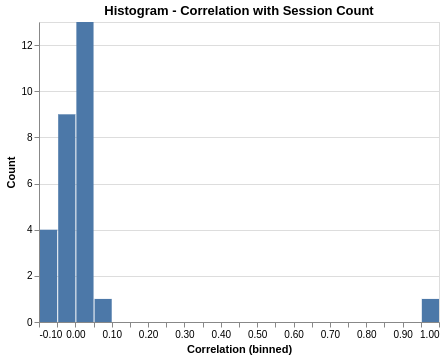

In [47]:
# linear correlation between sessions and pca transormed data
alt.Chart(temp).mark_bar().encode(
    alt.X("unacast_session_count:Q", bin=alt.Bin(maxbins=30),title="Correlation (binned)"),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Correlation with Session Count'
)

In [37]:
# dropping columns with at least 60% zero rate
df_pca_2 = df_pca.drop((df_desc[df_desc['zero']>0.6].index), axis=1)

In [32]:
pca2 = PCA(n_components=100)
pca2.fit(df_pca_2)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [33]:
#list of numbers between 1 and 100
no_of_vectors = [i for i in range(1,101)]
# list of sum of var explained by n first vectors
explained_variance = [round(sum(pca2.explained_variance_ratio_[:i]),4) for i in range(1,101)]
#sum(pca.explained_variance_ratio_[:27])
d = {'num_of_vectors': no_of_vectors, 'total_explained_variance': explained_variance, 'marginal_explained_variance':list(pca2.explained_variance_ratio_)}
pca2_output = pd.DataFrame(data=d).set_index('num_of_vectors')

In [34]:
pca2_output[:30]

total_explained_variance  marginal_explained_variance
num_of_vectors                                                       
1                                 0.5823                     0.582312
2                                 0.7244                     0.142075
3                                 0.7679                     0.043527
4                                 0.7991                     0.031229
5                                 0.8291                     0.029943
6                                 0.8517                     0.022584
7                                 0.8711                     0.019449
8                                 0.8888                     0.017709
9                                 0.9059                     0.017106
10                                0.9211                     0.015180
11                                0.9336                     0.012510
12                                0.9425                     0.008891
13                                0.9510                     0.008460
14                                0.9584                     0.007393
15                                0.9649                     0.006509
16                                0.9712                     0.006316
17                                0.9767                     0.005529
18                                0.9819                     0.005225
19                                0.9860                     0.004017
20                                0.9893                     0.003350
21                                0.9924                     0.003065
22                                0.9946                     0.002226
23                                0.9962                     0.001602
24                                0.9977                     0.001459
25                                0.9990                     0.001333
26                                0.9993                     0.000252
27                                0.9995                     0.000220
28                                0.9996                     0.000105
29                                0.9997                     0.000085
30                                0.9997                     0.000057

In [44]:
X = df_census.drop(columns = ['external_id', 'unacast_session_count'])
y = df_census['unacast_session_count']

X = X.fillna(0)
y = y.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Z = pca.transform(df_pca_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 2020)
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Test accuracy is :")
y_preds = lr.predict(X_test)                 
rmse = mean_squared_error(y_test, y_preds, squared=False)
r2 = r2_score(y_test, y_preds)
print("Root mean squared error: %0.3f and r^2 score: %0.3f" % (rmse,r2))

Test accuracy is :
Root mean squared error: 684.434 and r^2 score: 0.082
